In [63]:
# First import all dependencies
import math
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torch.amp import autocast, GradScaler

In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2025-06-09 16:21:47--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-06-09 16:21:47--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  3.93MB/s    in 88s     

2025-06-09 16:23:16 (2.69 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

^C


In [2]:
!ls -la tiny-imagenet-200/tiny-imagenet-200/

total 12429
drwxrwxrwx   5 root root 2022854 Jun  9 17:09 .
drwxrwxrwx   3 root root 2022854 Jun  9 17:53 ..
drwxrwxrwx   3 root root 2001889 Dec 12  2014 test
drwxrwxrwx 202 root root 2018827 Dec 12  2014 train
drwxrwxrwx 202 root root 2001884 Jun  9 18:12 val
-rw-rw-rw-   1 root root    2000 Feb  9  2015 wnids.txt
-rw-rw-rw-   1 root root 2655750 Feb  9  2015 words.txt


In [64]:
!head -5 tiny-imagenet-200/tiny-imagenet-200/val/val_annotations.txt



val_0.JPEG	n03444034	0	32	44	62
val_1.JPEG	n04067472	52	55	57	59
val_2.JPEG	n04070727	4	0	60	55
val_3.JPEG	n02808440	3	3	63	63
val_4.JPEG	n02808440	9	27	63	48


In [65]:
ROOT_DIR = 'tiny-imagenet-200/tiny-imagenet-200'

In [10]:
import os
import shutil

val_dir = os.path.join(ROOT_DIR, 'val')
val_annotations = os.path.join(val_dir, 'val_annotations.txt')
val_images_dir = os.path.join(val_dir, 'images')

with open(val_annotations, 'r') as f:
  for line in f.readlines():
    split_lines = line.split('\t')
    image_name = split_lines[0]
    class_name = split_lines[1]
    target_dir = os.path.join(val_dir, class_name)

    if not os.path.exists(target_dir):
      os.makedirs(target_dir)

    src_path = os.path.join(val_images_dir, image_name)
    dst_path = os.path.join(target_dir, image_name)
    shutil.move(src_path, dst_path)

In [17]:
shutil.rmtree(val_images_dir)

In [66]:
!ls -la tiny-imagenet-200/tiny-imagenet-200/val/   | head -7
!ls -la tiny-imagenet-200/tiny-imagenet-200/val/n01443537/ | head -7

total 201487
drwxrwxrwx 202 root root 2001884 Jun  9 18:12 .
drwxrwxrwx   5 root root 2022854 Jun  9 17:09 ..
drwxrwxrwx   2 root root 1008408 Jun  9 18:08 n01443537
drwxrwxrwx   2 root root 1011156 Jun  9 18:08 n01629819
drwxrwxrwx   2 root root 1010161 Jun  9 18:08 n01641577
drwxrwxrwx   2 root root 1010452 Jun  9 18:08 n01644900
ls: write error: Broken pipe
total 3035
drwxrwxrwx   2 root root 1008408 Jun  9 18:08 .
drwxrwxrwx 202 root root 2001884 Jun  9 18:12 ..
-rw-rw-rw-   1 root root    1781 Dec 12  2014 val_1230.JPEG
-rw-rw-rw-   1 root root    1307 Dec 12  2014 val_1267.JPEG
-rw-rw-rw-   1 root root    1732 Dec 12  2014 val_1284.JPEG
-rw-rw-rw-   1 root root    1448 Dec 12  2014 val_1551.JPEG


In [67]:
IMG_SIZE = 64
BATCH_SIZE= 128
IN_CHANNELS = 3
EMBED_DIM = 512
PATCH_SIZE = 4
NUM_HEADS = 8 # For multi attention layer
DEPTH = 12 # Number of tarnsformer layers
DROPOUT = 0.1
MPL_DIM = 1024
NUM_CLASSES = 200 # Numbe of categories in TinyImageNet
TOTAL_EPOCHS = 300
WARM_UP_EPOCHS = 10
EMA_DECAY = 0.996

In [68]:
# Prepare the transformations to be done on each image
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

In [69]:
# Load the datasets
training_dataset = datasets.ImageFolder(ROOT_DIR+'/train', transform=transform)
validation_dataset = datasets.ImageFolder(ROOT_DIR+'/val', transform=transform)

In [70]:
# Load the data
training_data_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10, pin_memory=True, prefetch_factor=4, persistent_workers=True)
validation_data_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=10, pin_memory=True, prefetch_factor=4, persistent_workers=True)

In [71]:
### Model start ###
## First Patch Embedding ##
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels=3, embed_dim=128, patch_size=4, img_size=224):
    super().__init__()
    self.proj = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
    self.patch_size = patch_size
    self.num_patches = (img_size//patch_size) ** 2

  def forward(self, x):
    x = self.proj(x) # B, embed_dim, H/P, W/P
    x = x.flatten(2) # B, embed_dim, N
    x = x.transpose(1,2) # B, N, embed_dim
    return x

class ViT(nn.Module):
  def __init__(self, in_channels, embed_dim, patch_size, img_size, num_heads, dropout, mlp_dim, depth, num_classes):
    super().__init__()
    self.patch = PatchEmbedding(in_channels=in_channels, embed_dim=embed_dim, patch_size=patch_size, img_size=img_size)
    num_patches = self.patch.num_patches
    self.dropout = nn.Dropout(dropout)
    self.cls = nn.Parameter(torch.zeros((1, 1, embed_dim)))
    self.positions = nn.Parameter(torch.ones(1, num_patches+1, embed_dim))

    encoding_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,dim_feedforward=mlp_dim, dropout=dropout, batch_first=True)
    self.encoding_transformer = nn.TransformerEncoder(encoder_layer=encoding_layer, num_layers=depth)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    x = self.patch(x)
    B = x.shape[0]
    cls = self.cls.expand(B, -1, -1)
    x = torch.cat((cls,x), dim=1)
    x = x + self.positions[:, :x.shape[1], :]
    x = self.encoding_transformer(x)
    x = self.norm(x)
    return self.dropout(self.head(x[:,0]))






In [72]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.min_delta = min_delta
        self.patience = patience
        self.early_stop = False
        self.best_value = None
        self.counter = 0
    def __call__(self, val):
        if self.best_value is None:
            self.best_value = val

        if val > self.best_value - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.counter = 0
            self.best_value = val

In [73]:
class EMA(nn.Module):
    def __init__(self, model, decay, device):
        super().__init__()
        self.ema_model = copy.deepcopy(model)
        self.ema_model.eval()
        self.decay = decay
        self.device = device

        for parameters in self.ema_model.parameters():
            parameters.requires_grad = False

    def update(self, model):
        with torch.no_grad():
            for ema_param, model_param in zip(ema_model.parameters(), model.parameters()):
                ema_param.data.mul_(self.decay).add_(model_param.data, alpha=1-self.decay)

    def forward(self, *args, **kwargs):
        return self.ema_model(*args, **kwargs)

    def to(self, device):
        self.device = device
        self.ema_model.to(device)
    def state_dict(self):
        return self.ema_model.state_dict()

    def load_state_dict(self, state_dict):
        self.ema_model.load_state_dict(state_dict)
                

In [74]:
#### Traning loop ###
def train(model, loader, optimizer, criterion, device, scaler, ema_model):
  model.train()
  total_correct = 0
  total_loss = 0
  total = 0
  for images, label in loader:
    images = images.to(device, non_blocking=True)
    label = label.to(device, non_blocking=True)
    optimizer.zero_grad()

    with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
      output = model(images)
      loss = criterion(output, label)

    scaler.scale(loss).backward() # scale backward propagation
    scaler.step(optimizer)        # scaled optimizer step
    scaler.update()               # scale update for next iteration

    ema_model.update(model)       # update the parameters for EMA model
      
    total_loss += loss.item() * images.size(0)
    total_correct += (output.argmax(dim=1)==label).sum().item()
    total += label.size(0)
  return total_loss/total, total_correct/total

In [75]:
## Validation loop ##

def validate(model, loader, criterion, device):
  total_correct = 0
  total_loss = 0
  total = 0
  with torch.no_grad():
    for images, label in loader:
      images = images.to(device, non_blocking=True)
      label = label.to(device, non_blocking=True)

      with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
        output = model(images)
        loss = criterion(output, label)

      total_loss += loss.item() * images.size(0)
      total_correct += (output.argmax(dim=1)==label).sum().item()
      total += label.size(0)
  return total_loss/total, total_correct/total


In [76]:
def learning_rate_lambda(current_epoch):
    # Based upon SGDR: Stochastic Gradient Descent with Warm Restarts
    if current_epoch < WARM_UP_EPOCHS:
        # Linear warmup
        return float(current_epoch)/ float(WARM_UP_EPOCHS)
    else:
        # Cosine decay
        # The below ranges from 0 to ~1
        progress = (current_epoch - WARM_UP_EPOCHS)/(TOTAL_EPOCHS - WARM_UP_EPOCHS)

        # This one ranges from -1 to 1 through cos(); and then shift and scaled between 0 and 1
        return 0.5 * (1. + math.cos(math.pi * progress))


In [86]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT(IN_CHANNELS, EMBED_DIM, PATCH_SIZE, IMG_SIZE, NUM_HEADS, DROPOUT, MPL_DIM, DEPTH, NUM_CLASSES)
ema_model = EMA(model, EMA_DECAY, device) 
model = model.to(device)
ema_model.to(device) 
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.01)
scaler = GradScaler()
epochs = 400
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, learning_rate_lambda)


In [78]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
params


25494216

In [79]:
def save_checkpoint(model, optimizer, scheduler, epoch, loss, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'ema_model_state_dict' : ema_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
    }, path)
    

In [80]:
def load_checkpoint(path):
    checkpoint = torch.load(path, map_location = 'cuda' if torch.cuda.is_available() else 'cpu')
    return checkpoint

In [88]:
# Initialize training and validation lists and load checkpoints
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []
early_stopping = EarlyStopping(patience = 20, min_delta = 0.001)

checkpoint = load_checkpoint('checkpoint1.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
if 'ema_model_state_dict' in checkpoint:
    ema_model.load_state_dict(checkpoint['ema_model_state_dict'])
last_val_loss = checkpoint['loss']
start_epoch = checkpoint['epoch'] + 1


inf

In [ ]:
for epoch in range(start_epoch, epochs):
  training_loss, training_accuracy = train(model, training_data_loader, optimizer, criterion, device, scaler, ema_model)
  validation_loss, validation_accuracy = validate(ema_model, validation_data_loader, criterion, device)
  training_losses.append(training_loss)
  training_accuracies.append(training_accuracy)
  validation_losses.append(validation_loss)
  validation_accuracies.append(validation_accuracy)
  print(f"Epoch: {epoch+1}/{epochs}")
  print(f"Training average loss: {training_loss}, accuracy: {training_accuracy}")
  print(f"Validation average loss: {validation_loss}, accuracy: {validation_accuracy}")
  scheduler.step()
  early_stopping(validation_loss)
  current_loss = float('inf') if not validation_losses else validation_losses[-1]
  if current_loss < last_val_loss: 
    last_val_loss = current_loss
    save_checkpoint(model, optimizer, scheduler, epoch, validation_losses[-1], 'checkpoint1.pth')
  if early_stopping.early_stop:
      print(f"Early stopping at {epoch+1} step")
      break


Epoch: 1/400
Training average loss: 5.4731303279113765, accuracy: 0.00493
Validation average loss: 5.453923408508301, accuracy: 0.0047
Epoch: 2/400
Training average loss: 5.251607746124267, accuracy: 0.01148
Validation average loss: 5.182844979858398, accuracy: 0.016
Epoch: 3/400
Training average loss: 5.11556624710083, accuracy: 0.02038
Validation average loss: 5.049205989074707, accuracy: 0.0272
Epoch: 5/400
Training average loss: 4.957263597717285, accuracy: 0.03552
Validation average loss: 4.869867472839355, accuracy: 0.0421
Epoch: 6/400
Training average loss: 4.865226974182129, accuracy: 0.04577
Validation average loss: 4.755492651367187, accuracy: 0.0561
Epoch: 7/400
Training average loss: 4.783056306152344, accuracy: 0.05529
Validation average loss: 4.668032637786865, accuracy: 0.0605
Epoch: 8/400
Training average loss: 4.71141260055542, accuracy: 0.06244
Validation average loss: 4.592928957366944, accuracy: 0.0725
Epoch: 9/400
Training average loss: 4.639239685974121, accuracy:

In [90]:
current_loss = float('inf') if not validation_losses else validation_losses[-1]
current_loss

3.140990619277954

In [24]:
current_loss = float('inf') if not validation_losses else validation_losses[-1]
if current_loss < last_val_loss: 
    save_checkpoint(model, optimizer, scheduler, epoch, validation_losses[-1], 'checkpoint1.pth')

In [92]:
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 45.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 163.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


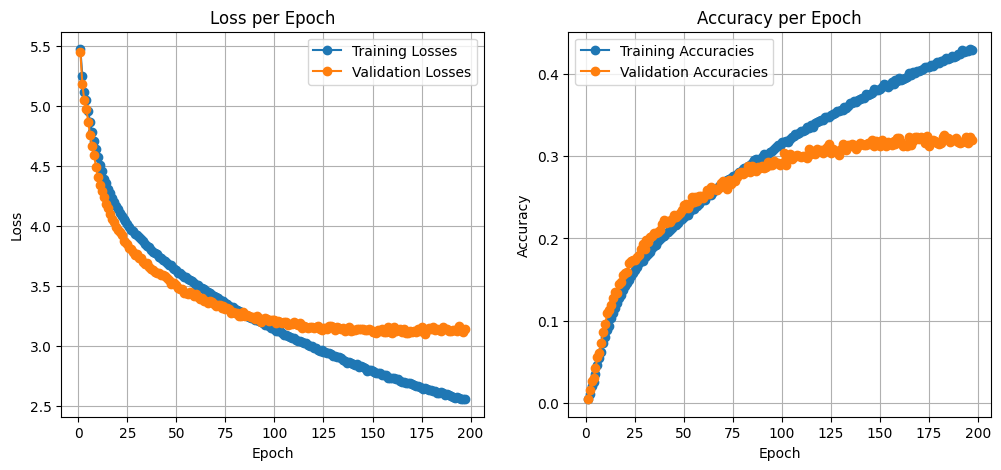

In [93]:
import matplotlib.pyplot as plt
new_epochs = list(range(1, len(training_losses)+1))
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(new_epochs, training_losses, label="Training Losses", marker='o')
plt.plot(new_epochs, validation_losses, label="Validation Losses", marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(new_epochs, training_accuracies, label="Training Accuracies", marker='o')
plt.plot(new_epochs, validation_accuracies, label="Validation Accuracies", marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()